# Youtube Trending Videos

### Import Modules

In [170]:
import pandas as pd
import json
from datetime import datetime
import matplotlib.pyplot as plt
% matplotlib inline
from wordcloud import STOPWORDS, WordCloud
import seaborn as sns
import numpy as np
import string
import matplotlib.patches as mpatches

## Data Preprocessing 

### Dataset Description
** A dataset of Youtube's daily Trending videos' stats from Nov'17 to Jun'18. **

https://www.kaggle.com/datasnaek/youtube-new/home

In [171]:
df = pd.read_csv("USvideos.csv")

In [172]:
df.head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


In [173]:
df.columns

Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'thumbnail_link', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'description'],
      dtype='object')

In [174]:
df.rename(columns={'comment_count': 'comments'}, inplace=True)

In [175]:
# Add a "category" column. A json file is used to find the relevant category of a category_id.
category_dict = {}
with open("US_category_id.json") as json_data:
    d = json.load(json_data)
    for item in d["items"]:
        category_dict[int(item["id"])] = item["snippet"]["title"]
category_dict[29] = "Nonprofits & Activism"
df["category"] = df["category_id"].map(category_dict)

In [176]:
# Format the 'trending_date' column.
df["trending_date"] = df['trending_date'].apply(lambda x: datetime.strptime(x, "%y.%d.%m"))

In [177]:
# Add a 'trending_month' column.
df["trending_month"] = df['trending_date'].apply(lambda x: datetime.strftime(x, "%y-%m")) 

In [178]:
# Add a 'like_percentage' and a 'total_votes' column.
df['total_votes'] = df['likes'] + df['dislikes']
df['like_pct'] = df['likes'] / df['total_votes']

In [179]:
# "Views" are cumulative and the very same video can have an increasing numbers of views as the day passes. 
# So we only need the largest view number for the same video, or, the last time it appears in the dataset.
# Remove punctuations and convert 'title's to lower cases before aggregating views (also replace double spaces with one).
df['title'] = df['title'].str.replace('[{}]'.format(string.punctuation), '')
df['title'] = df['title'].str.replace('  ', ' ')
df['title'] = [title.lower() for title in df['title']]
df_aggregate_views = df.groupby(['title'], sort=False)[['views']].max().reset_index()
df_aggregate_views = df.merge(df_aggregate_views, on=['title','views'])

## Data Analysis and Visualization

### Monthly Trends

([<matplotlib.axis.YTick at 0x119fe62b0>,
 <a list of 5 Text yticklabel objects>)

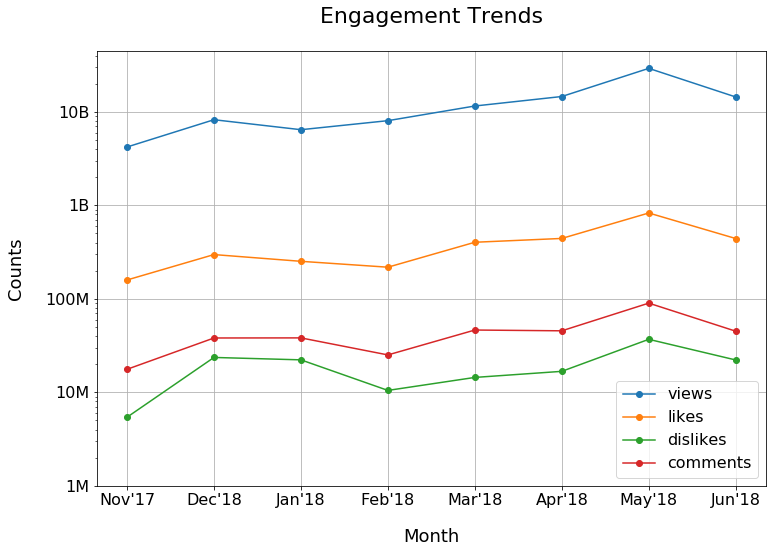

In [180]:
df_monthly = df.groupby('trending_month').sum()
df_monthly[['views', 'likes', 'dislikes', 'comments']].plot(style='o-', logy=True, figsize=(12, 8), fontsize=16, grid=True)
plt.ylabel('Counts', labelpad=20, fontsize=18)
plt.xlabel('Month', labelpad=20, fontsize=18)
plt.legend(fontsize=16)
plt.title('Engagement Trends', y=1.05, fontsize=22)
plt.xticks(range(0, 8), ['Nov\'17', 'Dec\'18', 'Jan\'18', 'Feb\'18', 'Mar\'18', 'Apr\'18', 'May\'18', 'Jun\'18'], fontsize=16)
plt.yticks([1E6, 1E7, 1E8, 1E9, 1E10], ['1M', '10M', '100M', '1B', '10B'], fontsize=16)

### Insights
1. Overall, all metrics (views, likes, dislikes, comment_about) increase from Nov'17 to June'18.
2. All metrics have a high correlation with each other.
3. All metrics have a local peak in Dec'17, probably because people spent more time watching videos during Christmas and New Year holidays.
4. All metrics have a global peak in May'18, which is worthnoting. We'll further explore it.

## Category Popularity

### 1. What is the most popular category?

In [181]:
df_categories = df_aggregate_views.groupby('category').sum()[['views']].sort_values(by='views', ascending=False)

([<matplotlib.axis.YTick at 0x1a1d33fc18>,
 <a list of 5 Text yticklabel objects>)

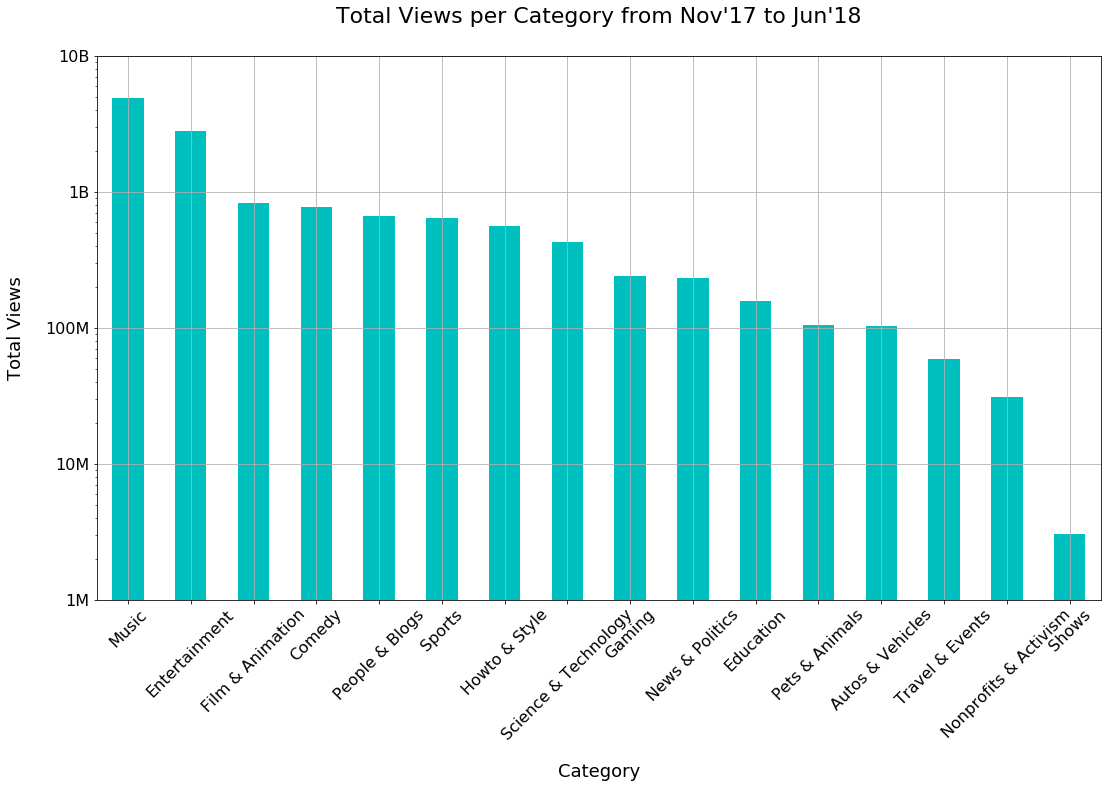

In [182]:
df_categories.plot(kind='bar', figsize=(18, 10), logy=True, legend=None, color='c', grid=True)
plt.title('Total Views per Category from Nov\'17 to Jun\'18', y=1.05, fontsize=22)
plt.xlabel('Category',  labelpad=20,fontsize=18)
plt.ylabel('Total Views', labelpad=20, fontsize=18)
plt.xticks(rotation=45, fontsize=16)
plt.yticks([1E6, 1E7, 1E8, 1E9, 1E10], ['1M', '10M', '100M', '1B', '10B'], fontsize=16)

In [183]:
#Create sub-dataframe for boxplot.
df_categories2 = df.pivot_table(index='trending_date', columns='category', values='views', aggfunc='sum')
#Sort the dataframe by medians.
meds = df_categories2.median()
meds = meds.sort_values(ascending=False)
df_categories2 = df_categories2[meds.index]

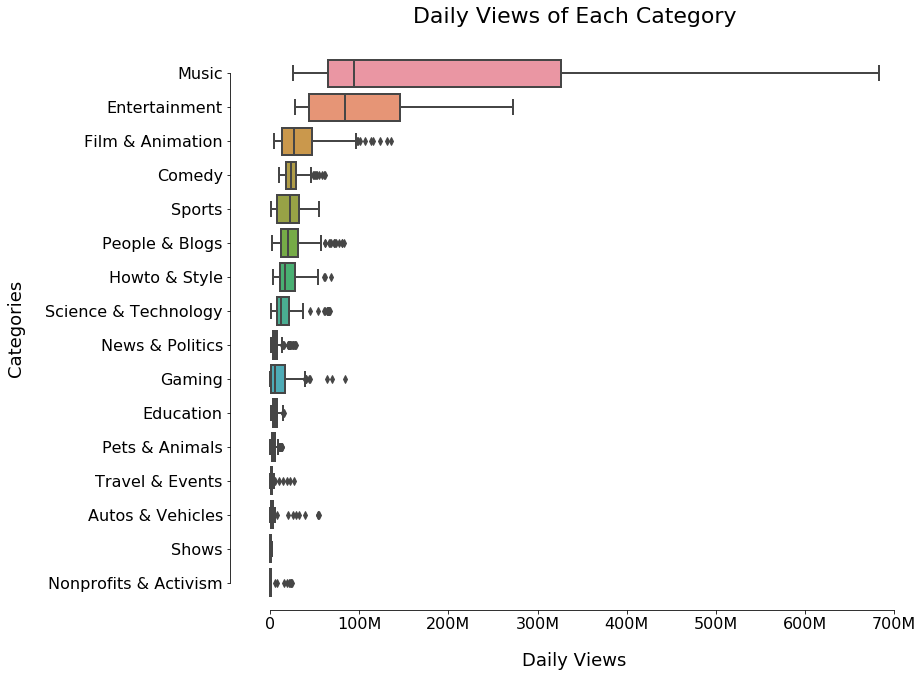

In [184]:
fig, ax = plt.subplots(figsize=(12, 10))
box = sns.boxplot(linewidth=2, orient='h', ax=ax, data=df_categories2)
box.axes.set_title('Daily Views of Each Category', y=1.05, fontsize=22)
box.set_xlabel('Daily Views', labelpad=20, fontsize=18)
box.set_ylabel('Categories', labelpad=20, fontsize=18)
box.tick_params(labelsize=16)
plt.xticks([0, 1E8, 2E8, 3E8, 4E8, 5E8, 6E8, 7E8], ['0', '100M', '200M', '300M', '400M', '500M', '600M', '700M'])
sns.despine(offset=10, trim=True)

### Insights
1. The top 2 popular categories are 'Music' and 'Entertainment'. Their views are far more than the other categories.
2. This insight corresponds to the last section as 'official', 'trailer' both belong to these two categories. 
3. We further confirm 'Music' and 'Entertainment' are the most popular categories from the BoxPlot. We can also see there are large outliers in the 'Music' category from the numbers of views perspective.

## Topic Popularity 

### 1. What is the most popular(top viewed) videos by its title?

In [185]:
def GenerateWordCloud(df, ignore_words=tuple(), fontsize_range=(10, 42), figsize=(900, 300), relative_scaling=0.4):
    """Given a dataframe, it will parse the 'title' column into words and 
    generate a word cloud object based on the number of video views.
    ignore_words: excludes the words in the word cloud."""
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(
                          background_color='white', 
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         )
    word_views_count = dict()
    # Parse the 'title' into a word frequency dictionary
    for index, row in df.iterrows():
        word_freq = wordcloud.process_text(row['title'])
        # The frequency is weighted with the total views of the video
        for k,v in word_freq.items():
            if k in ignore_words:
                continue
            if k in word_views_count.keys():
                word_views_count[k] += v * row['views']
            else:
                word_views_count[k] = v * row['views']
   # word_views_count = dict(sorted(word_views_count.items(), key=lambda x: -x[1])[:50])
    
    wordcloud = WordCloud(
                          prefer_horizontal=1,
                          relative_scaling=relative_scaling,
                          width=figsize[0], height=figsize[1],
                          background_color='white',
                          stopwords=stopwords,
                          max_words=50,
                          min_font_size=fontsize_range[0],
                          max_font_size=fontsize_range[1], 
                          random_state=42
                         ).generate_from_frequencies(word_views_count)
    return wordcloud

In [186]:
wordcloud_df = GenerateWordCloud(df, fontsize_range= (13, 50), figsize=(600, 400))

Text(0.5,1,'Word Cloud of Video Titles')

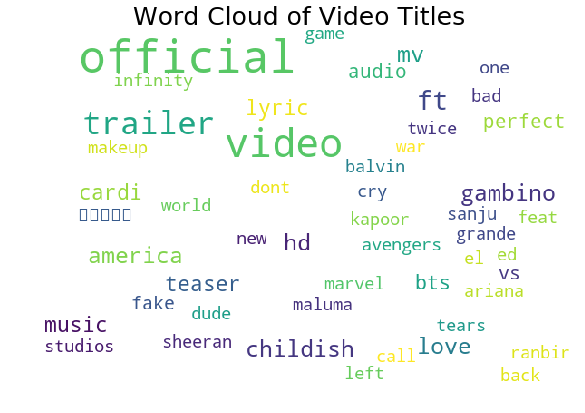

In [187]:
plt.figure(figsize=(12, 8), dpi=60)
plt.imshow(wordcloud_df)
plt.axis('off')
plt.title('Word Cloud of Video Titles', fontsize=30)

### Insights
Based on the word cloud, we can see that the most viewed videos are titles containing 'official' 'videos' and 'trailers'.

### 2. Which categories do the 'Official' videos belong to?

Text(0,0.5,'')

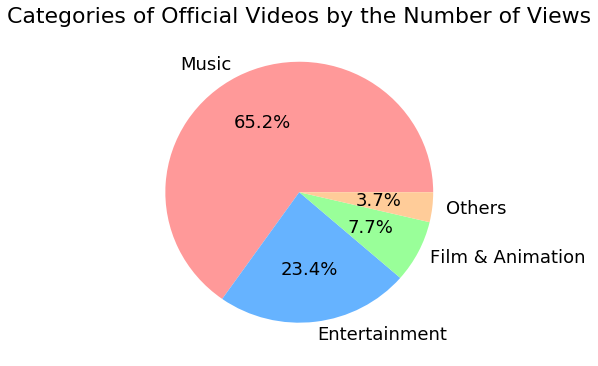

In [188]:
official_videos = df[df['title'].str.lower().str.contains('official')]
views = official_videos.groupby('category').agg({'views':'sum'})['views'].sort_values(ascending=False)
views_pct = views / sum(views)
# Get top 3 viewed categories and aggregate the other categories into a single 'Others' category.
views_pct = views_pct[0:3]
views_pct['Others'] = 1 - sum(views_pct)
views_pct.plot.pie(autopct='%1.1f%%', figsize=(6, 6), fontsize=18, colors=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])
plt.title('Categories of Official Videos by the Number of Views', fontsize=22)
plt.ylabel('')

### Insights

Among the views of official videos, the top 3 catogories are 'Music', 'Entertainment' and 'Film & Animation'.

### 3. What is the most popular word for 'Official' videos?

Text(0.5,1,'Word Cloud of Video Titles')

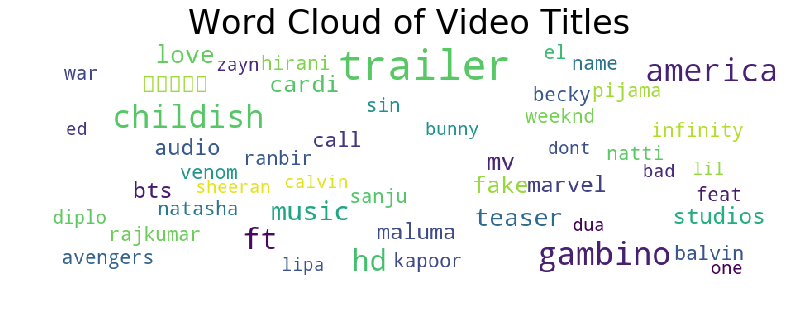

In [189]:
official_videos = df[df['title'].str.contains('official')]
wordcloud = GenerateWordCloud(official_videos, ignore_words=('official', 'video'), fontsize_range=(14, 50), relative_scaling=0.4)
plt.figure(figsize=(12, 8), dpi=80)
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Word Cloud of Video Titles', fontsize=30)

### Insights
1. 'Trailer' videos are the most popular 'official' videos. It means 'Official' and 'Trailer' come together frequently in video titles.
2. The most popular topic is 'Childish Gambino', a music artist.

### 4. Which categories do 'Trailer' videos belong to?


Text(0,0.5,'')

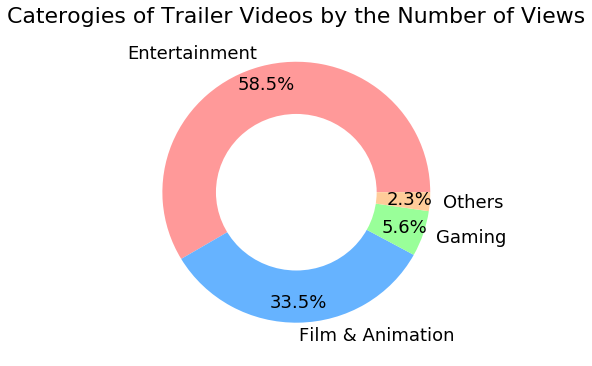

In [190]:
trailer_videos = df[df['title'].str.lower().str.contains('trailer')]
views = trailer_videos.groupby('category').agg({'views':'sum'})['views'].sort_values(ascending=False)
views_pct = views / sum(views)
views_pct = views_pct[0:3]
views_pct['Others'] = 1- sum(views_pct)
#draw circle
centre_circle = plt.Circle((0, 0), 0.60, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
views_pct.plot.pie(autopct='%1.1f%%', figsize=(6, 6), fontsize=18, colors=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'],
                   pctdistance=0.85)
plt.title('Caterogies of Trailer Videos by the Number of Views', fontsize=22)
plt.ylabel('')

Text(0.5,1,'Word Cloud of Video Titles')

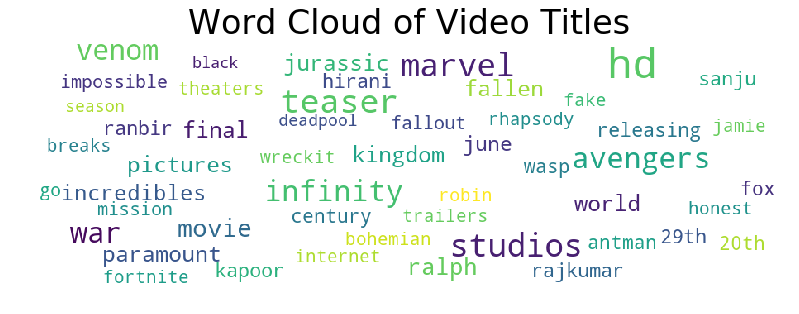

In [191]:
trailer_videos = df[df['title'].str.contains('trailer')]
wordcloud = GenerateWordCloud(trailer_videos, ignore_words=('official', 'trailer', 'video'), fontsize_range=(14, 50))
plt.figure(figsize=(12, 8), dpi=80)
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Word Cloud of Video Titles', fontsize=30)

### Insights
1. Among the views of trailer videos, the top catogories are 'Entertainment', 'Film & Animation' and 'Gaming'.
2. 'Official' is the most popular. It means 'Official' and 'Trailer' usually come together in video titles.
3. The most popular words are related to movie companies (e.g. 'Marvel','Studios'), and video quality word 'hd'.
4. Marvel movies such as Avengers, Deadpool, Infinity War are popular during these months.

### 5. What is the most popular(top viewed) "MUSIC" videos?

In [192]:
df_music = df[df['category'] == 'Music']

Text(0.5,1,'Word Cloud of Video Titles')

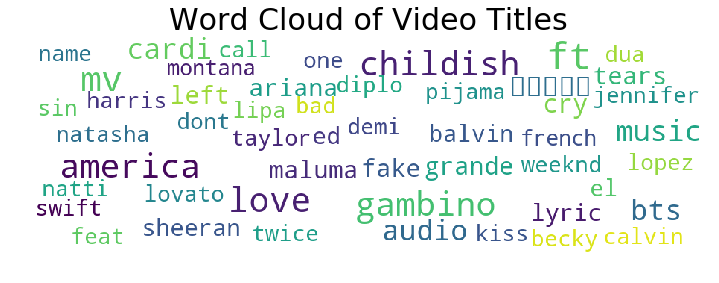

In [193]:
wordcloud = GenerateWordCloud(df_music, ignore_words=('official','video'), fontsize_range=(12, 50))
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Word Cloud of Video Titles', fontsize=30)

Apart from some singers' names, the keyword 'america' is top viewed. Thus, the top 10 viewed videos that contains 'america' are studied.

In [194]:
df_America = df_music[df_music['title'].str.lower().str.contains('america')].groupby('title', as_index=False).sum()
df_America['view_pct'] = df_America['views'] / df_America['views'].sum() * 100
df_America_top10_viewed = df_America[['title', 'view_pct']].sort_values(by='view_pct', ascending=False).head(10)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text yticklabel objects>)

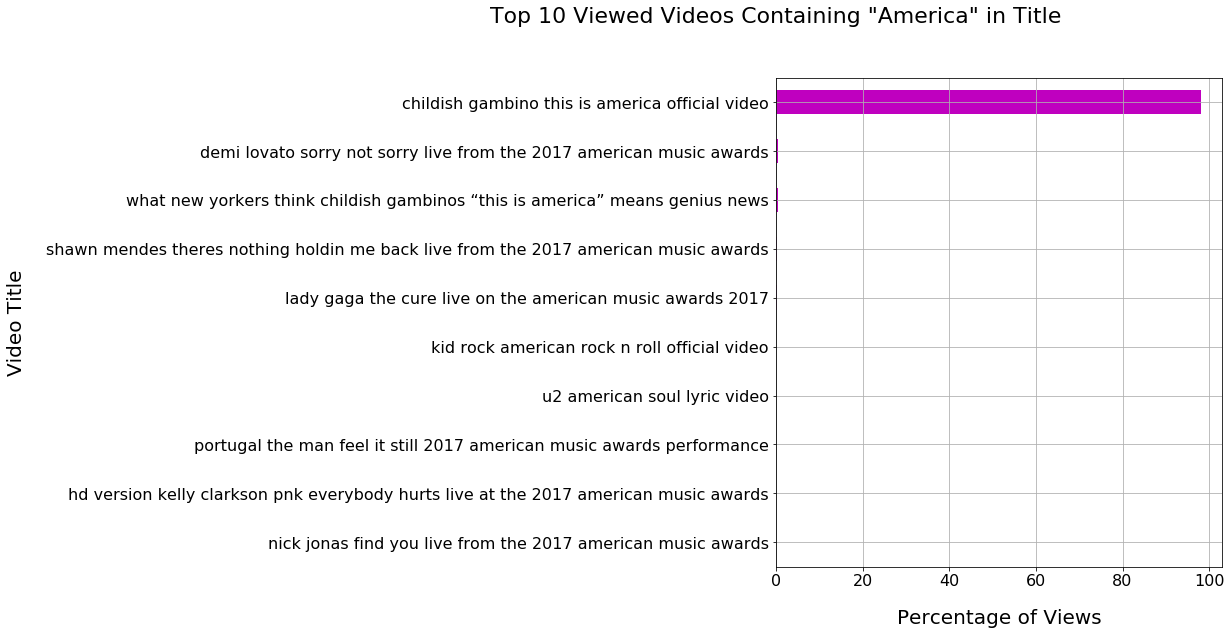

In [195]:
df_America_top10_viewed.sort_values(by='view_pct').plot(kind='barh', x='title', figsize=(8, 9), legend=None, color='m', grid=True)
plt.title('Top 10 Viewed Videos Containing "America" in Title',x=0, y=1.1, fontsize=22)
plt.xlabel('Percentage of Views', labelpad=20, fontsize=20)
plt.ylabel('Video Title', labelpad=20, fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

### Insights
1. We are seeing many pop artist names here. 'Childish' 'Gambino', 'Cardi', 'Ariana', 'Grande', 'Ed Sheeran', 'Jennifer' are the most popular ones among them during this period.
2. More than 95% of the occurrence of the keyword 'america' comes from the MV 'This is America' by 'Childish Gambino'.

## ‘Like Percentages’ Among Top 10 Music/Entertainment Videos

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 <a list of 7 Text yticklabel objects>)

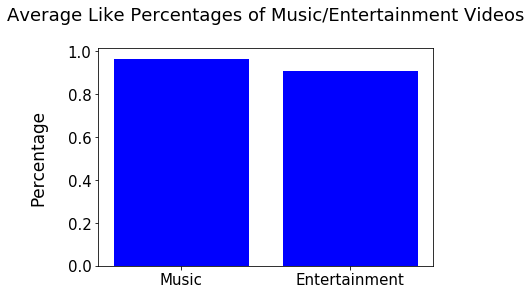

In [196]:
# Calculate the average 'like percentages' of 'Music' and 'Entertainment', respectively.
music_avg_like_pct = df_music_ent[(df_music_ent['category'] == 'Music')]['likes'].sum() / df_music_ent[(
                                                        df_music_ent['category'] == 'Music')]['total_votes'].sum()
                                                                                
ent_avg_like_pct = df_music_ent[(df_music_ent['category'] == 'Entertainment')]['likes'].sum() / df_music_ent[(
                                                    df_music_ent['category'] == 'Entertainment')]['total_votes'].sum()
pcts = [music_avg_like_pct, ent_avg_like_pct]

# Plot of the averages of these two categories
plt.bar(['Music', 'Entertainment'], pcts, color='b')
plt.title('Average Like Percentages of Music/Entertainment Videos', y=1.1, fontsize=18)
plt.ylabel('Percentage', labelpad=20, fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

Both categories seem to have a very high 'like percentage' with a little advantage towards 'Music'.

In [197]:
#Select top 10 viewed 'Music' or 'Entertainment' videos and sort by 'total_votes'.
df_music_ent = df_aggregate_views[(df_aggregate_views['category'] == 'Music') |
                                  (df_aggregate_views['category'] == 'Entertainment')]
df_music_ent_top10 = df_music_ent.sort_values(by='views', ascending=False).head(10)
df_music_ent_top10 = df_music_ent_top10[['title', 'like_pct','likes','dislikes','total_votes','views']].sort_values(by='total_votes')
df_music_ent_top10

,title,like_pct,likes,dislikes,total_votes,views
4850,maluma el préstamo official video,0.919386,815369,71494,886863,87264467
5785,the weeknd call out my name official video,0.972187,1427436,40837,1468273,122544931
5810,becky g natti natasha sin pijama official video,0.922476,1425496,119798,1545294,139334502
6353,cardi b bad bunny j balvin i like it official ...,0.946607,1816753,102474,1919227,94254507
534,luis fonsi demi lovato échame la culpa,0.953006,2376636,117196,2493832,102012605
1106,marvel studios avengers infinity war official ...,0.979955,2625661,53709,2679370,91933007
5749,ariana grande no tears left to cry,0.959826,3094021,129502,3223523,148689896
1382,youtube rewind the shape of 2017 youtuberewind,0.653114,3093544,1643059,4736603,149376127
6089,childish gambino this is america official video,0.935990,5023450,343541,5366991,225211923
6072,bts 방탄소년단 fake love official mv,0.964456,5613827,206892,5820719,123010920


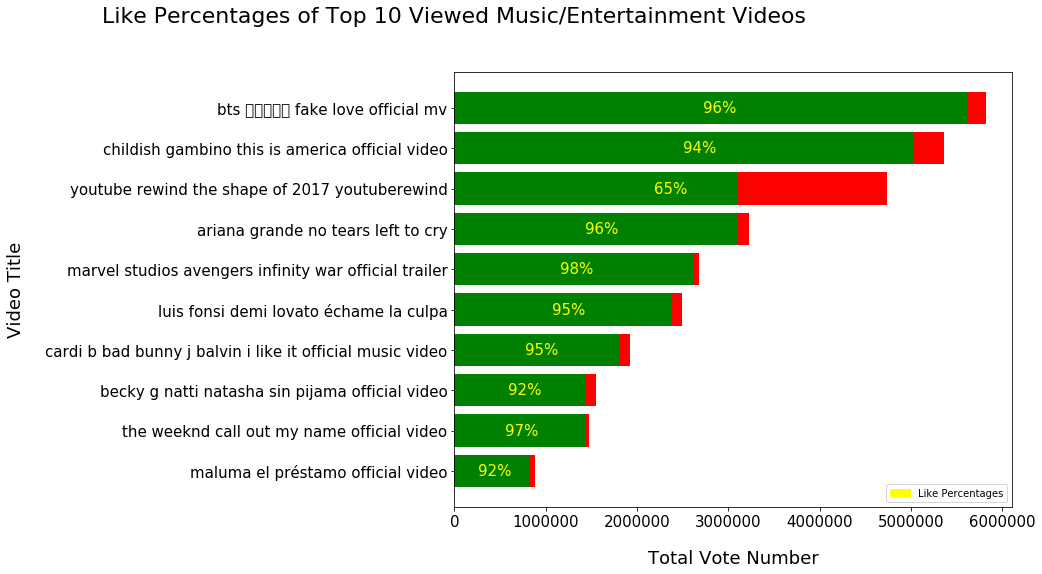

In [198]:
# Create figure
fig, ax1 = plt.subplots(figsize=(10,8))
# Create red Bars indicating 'dislikes'
plt.barh( title, df_music_ent_top10['total_votes'], color='r')
# Create green Bars indicating 'likes'
plt.barh( title, df_music_ent_top10['likes'], color='g')

# Change titles, labels, font sizes, etc.
plt.title('Like Percentages of Top 10 Viewed Music/Entertainment Videos', x=0, y=1.1, fontsize=22)
plt.xlabel('Total Vote Number', labelpad=20, fontsize=18)
plt.ylabel('Video Title', labelpad=20, fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Add 'like percentage' labels for each Title
labels = [str(round(i*100))+'%' for i in df_music_ent_top10['like_pct']]
rects = ax1.patches
for rect, label in zip(rects, labels):
    width = rect.get_width()
    ax1.text(width/2,rect.get_y() + rect.get_height()/2, label, ha='center',va='center', color='yellow', fontsize=15)

# Add legent for 'like percentage'
yellow_patch = mpatches.Patch(color='yellow', label='Like Percentages')
plt.legend(handles=[yellow_patch])

### Insights

1. Among the Top 10 viewed music/entertainment videos, YouTube Rewind: The Shape of 2017 has far more lower 'like percentage' than the other videos. In other words, it's the most disliked video among the top 10. Maybe the video is created by Youtube and they try to push selling it.
2. This finding tells us that sometimes people don't really like the content but were still attracted by it. This is probably because bad/unpleasant or controversial topics sometimes can draw more attentions and be more popular. 
3. Superhero movies seem to have the highest 'like percentage'.

## Conclusions

1. User engagement measured by the amount of views, likes, dislikes, and comments has increased from Nov'17 to Jun'18.
2. The top 2 popular categories are 'Music' and 'Entertainment'. Their views are far more than the other categories.
3. The most viewed videos are titles containing 'official' 'videos' and 'trailers'.
4. 'Trailer' videos are the most popular 'official' videos. It means 'Official' and 'Trailer' usually come together  in video titles.
5. Under Music category, pop artists' names appear the most in video titles. Among them, the top 1 title containing 'America' is related to Childish Gambino's 'This is America' MV. This MV surged in May-18, which caused the highest user engagement during this period.
6. Among the Top 10 viewed music/entertainment videos, YouTube Rewind: The Shape of 2017 has the lowest 'like percentage'.